In [3]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

In [4]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
dt = 0.2
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 50.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 0.1))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.0000003e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 7.805e+06, gradnorm = 2.488e+07, alpha = 4.167, improvement_ratio = 0.8042
Iteration 1, loss = 1.584e+06, gradnorm = 1.095e+08, alpha = 4.167, improvement_ratio = 0.7971
Iteration 2, loss = 1.332e+06, gradnorm = 5.058e+07, alpha = 3.284e+03, improvement_ratio = 0.1599
Iteration 3, loss = 2.922e+05, gradnorm = 1.374e+08, alpha = 100.0, improvement_ratio = 0.7809
Iteration 4, loss = 2.704e+04, gradnorm = 4.88e+07, alpha = 83.33, improvement_ratio = 0.9092
Iteration 5, loss = 1.736e+04, gradnorm = 2.701e+07, alpha = 125.0, improvement_ratio = 0.3651
Iteration 100, loss = 242.7, gradnorm = 3.636e+04, alpha = 9.346, improvement_ratio = 0.7072
Iteration 200, loss = 192.7, gradnorm = 3.624e+03, alpha = 0.03281, improvement_ratio = 0.7826
Line Search Failed!
Final Iteration Results
Iteration 227, loss = 192.7, gradnorm = 0.01078, alpha = 267.1, improvement_ratio = -1.128e+05
Model after smooth warm start
(x)' = 33.477 1 + 0.708 x + 3.614 y + -4.082 z + -1.335 x^2 + 2.074 x 

In [6]:
model.print()

(x)' = -1.906 1 + -9.899 x + 10.265 y
(y)' = 0.878 1 + 27.484 x + -0.992 y + -0.969 x z
(z)' = 2.282 1 + -2.756 z + 1.033 x y


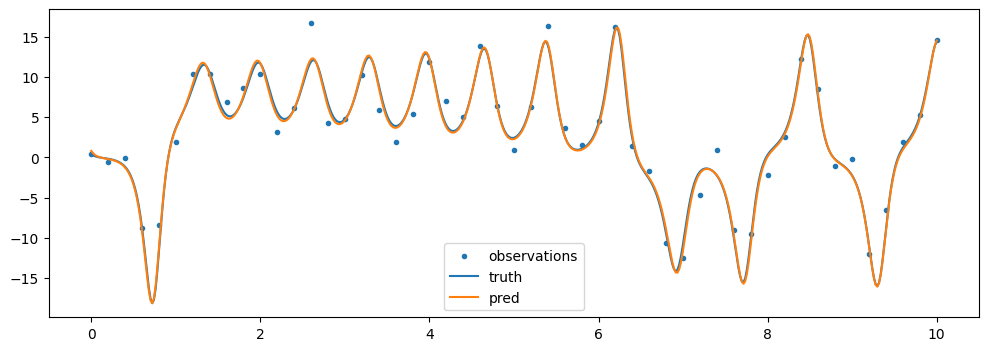

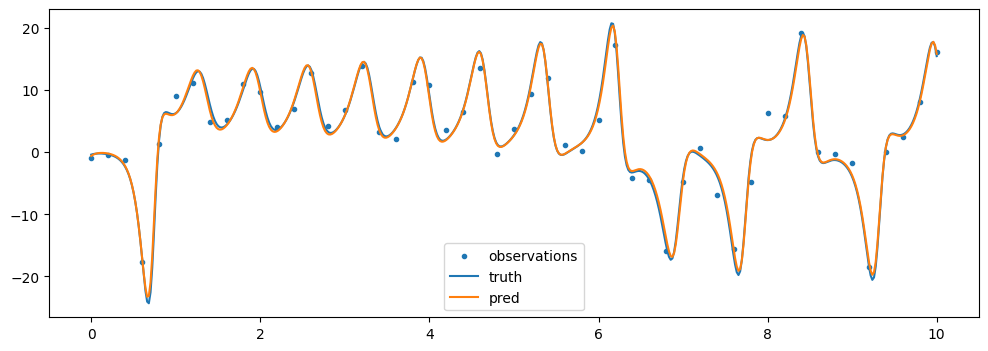

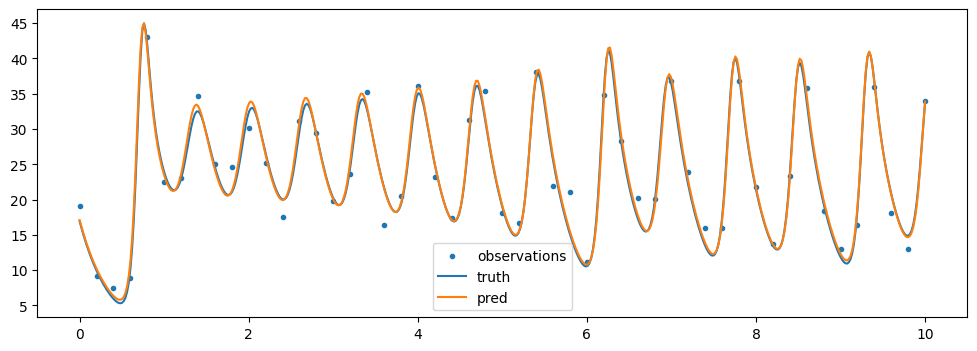

In [15]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


In [8]:
metrics

{'coeff_mets': {'precision': 0.7,
  'recall': 1.0,
  'f1': 0.8235294117647058,
  'coeff_rel_l2': 0.10011976331691304,
  'coeff_rmse': 0.5763371981374192,
  'coeff_mae': 0.20361091577413928},
 'data_mets': {'mse': Array(12.73710818, dtype=float64),
  'rmse': np.float64(3.568908541608639),
  'mae': np.float64(2.5907479652206424),
  'max_abs_error': np.float64(14.161315282422379),
  'normalized_mse': Array(0.00327403, dtype=float64),
  'relative_l2_error': np.float64(0.0572100226166287)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(1.0000003e-08, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

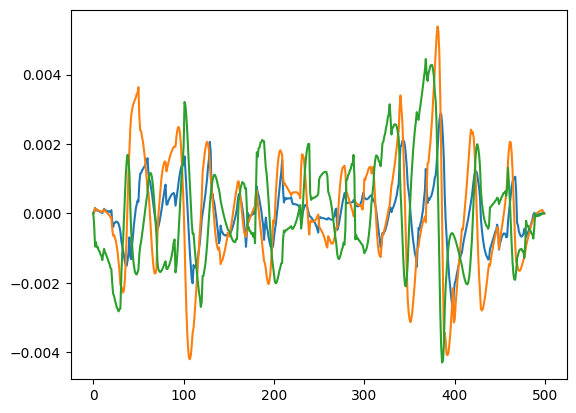

In [9]:
z = model.z
theta = model.theta
plt.plot(model.residuals.colloc_residual(z,theta)[::3])
plt.plot(model.residuals.colloc_residual(z,theta)[1::3])
plt.plot(model.residuals.colloc_residual(z,theta)[2::3])